In [1]:
import numpy as np
import os, sys
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class MovingObj:
    def __init__(self,center):
        self.previous_centers=[center]
        self.kalman=self.prepareKF()
        self.updateKF()
        self.num_frames_detected=1
        self.num_not_found=0
        self.is_being_tracked=False
        
    def prepareKF(self):
        kalman=cv2.KalmanFilter(4,2)
        kalman.measurementMatrix=np.array([[1,0,0,0],[0,1,0,0]],np.float32)
        kalman.transitionMatrix = np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]],np.float32)
        kalman.processNoiseCov=0.03*np.eye(4).astype(np.float32)
        kalman.measurementNoiseCov = 0.03*np.eye(2).astype(np.float32)
        return kalman
        
    def updateKF(self):
        self.kalman.correct(np.array(self.previous_centers[-1],dtype=np.float32))
        
    def lastcenter(self):
        return self.previous_centers[-1]

    def predictnow(self):
        if self.num_frames_detected<10 or not self.is_being_tracked:
            return list(self.lastcenter())
        if self.is_being_tracked:
            return self.kalman.predict()[:2][:,0]


    def addcenter(self,cen):
        self.previous_centers.append((cen[0],cen[1]))
        self.updateKF()
        self.num_frames_detected+=1
        self.num_not_found=0
        if self.num_frames_detected>=3:
            self.is_being_tracked=True
    
    def drop(self):
        self.num_not_found+=1
        if self.num_not_found>30:
            self.is_being_tracked=False
        
    def track_points(self):
        if self.is_being_tracked:
            return (self.previous_centers[-2],self.previous_centers[-1])

In [3]:
def computepairwise(matrix1,matrix2):
    assert len(matrix1.shape)==2, 'First argument is not 2D'
    assert len(matrix2.shape)==2, 'Second argument is not 2D'
    assert matrix1.shape[1]==matrix2.shape[1], 'Matrices have different number of features'
    
    result=np.zeros((matrix1.shape[0],matrix2.shape[0]),dtype=np.float32)
    for feature in range(matrix1.shape[1]):
        diff=(np.repeat(matrix1[:,feature][:,None],matrix2.shape[0],axis=1)-matrix2[:,feature][:,None].T) #,axis=1
        #print(diff.shape,matrix1.shape[0],matrix2.shape[0])
        assert diff.shape==(matrix1.shape[0],matrix2.shape[0]), 'there is a bug in your program'
        result += diff**2
    return np.sqrt(result)

In [4]:
def matchcentertoobj(centers,tracked_objs):
    current_predictions=np.array([list(obj.lastcenter()) for obj in tracked_objs]) #list(obj.lastcenter())
    #current_predictions=current_predictions[:,:,0] #obj.predictnow()
    #print(current_predictions.shape)
    #Nx2 array
    #centers is Mx2 array
    #compute pairwise distances (NxM)
    #if M<N be careful
    #if M >= N, possibly match existing centers to new centers if distance is below a threshold, 
    #maintain a list of used indices
    #match existing centers to that new center with which it has minimum distance
    centers=np.array(centers)
    #print(current_predictions.shape)
    distance=computepairwise(current_predictions,centers) #NxM
    #print(distance)
    possible_matches=np.argmin(distance,axis=1)
    used_indices=[]
    
    for idx in range(len(possible_matches)):
        #if match occurs more than once, choose the minimum distance
        candidates=[]
        candidates.append(distance[idx,possible_matches[idx]])
        for idx2 in range(len(possible_matches[idx+1:])):
            if possible_matches[idx]==possible_matches[idx+1+idx2]:
                candidates.append(distance[idx+1+idx2,possible_matches[idx]])
        
        if len(candidates)>1:
            pass
            #print('Duplicate matches found') #this happens VERY often
        if np.argmin(candidates) != 0:
            #this means another point has lower distance than this point, so this point has no matches
            tracked_objs[idx].drop()
        else:
            #print(candidates)
            if candidates[0]<50:               
                if possible_matches[idx] not in used_indices:
                    tracked_objs[idx].addcenter(centers[possible_matches[idx]])
                    used_indices.append(possible_matches[idx])
            else:
                tracked_objs[idx].drop()

In [5]:
def drawtrajectory(previous,this_frame):
    #previous: a dark frmae like matrix with only the trajectories drawn
    #this_frame: frame on which to draw trajectory
    for obj in tracked_objs:
        if obj.track_points() is not None:
            #print(obj.track_points())
            previous=cv2.line(previous,obj.track_points()[0],obj.track_points()[1],255,1)
    
    #this_frame[:,:,:] = this_frame[:,:,:]*((previous[:,:])[:,:,np.newaxis])
    data32=this_frame[:,:,1].astype(np.int32)
    np.clip(data32+previous,0,255,out=data32)
    this_frame[:,:,1]=data32.astype(np.uint8)
    return previous,this_frame

In [6]:
def writedistances(frame,tracked_objs,etime):
    finddist= lambda tp1,tp2: np.sqrt((tp1[0]-tp2[0])**2+(tp1[1]-tp2[1])**2)
    for obj in tracked_objs:
        if obj.num_frames_detected>5:
            center= lambda : tuple((np.array(obj.previous_centers[0])+np.array(obj.previous_centers[-1]))//2)
            #dist=[finddist(obj.previous_centers[idx-1],obj.previous_centers[idx]) for idx in range(1,obj.num_frames_detected)]
            #dist=np.sum(dist)
            #text_s='S={:.1f} um'.format(dist*0.64)
            disp=finddist(obj.previous_centers[0],obj.previous_centers[-1])
            text_d='D={:.1f} um'.format(disp*0.64)
            text_v='v={:.1f} um/s'.format(disp*0.64/etime)
            #cv2.putText(frame,text_s, obj.lastcenter(),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255))
            frame=cv2.line(frame,obj.previous_centers[0],obj.previous_centers[-1],(255,0,255),1)
            cv2.putText(frame,text_d, center() ,cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255))
            cv2.putText(frame,text_v, (center()[0],center()[1]+25) ,cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255))
    return frame

In [26]:
freq = 2
video=cv2.VideoCapture(str(freq)+'_hertz (Converted).mov')

filename='motion_'+str(freq)+'.m4v'

if os.path.exists(filename):
    os.remove(filename)
    
fps=video.get(cv2.CAP_PROP_FPS)
size=(int(video.get(cv2.CAP_PROP_FRAME_WIDTH)),int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))
videoWriter=cv2.VideoWriter(filename,cv2.VideoWriter_fourcc('I','4','2','0'),fps,size)

In [27]:
num_frames_in_history=5

In [28]:
fgbg=cv2.createBackgroundSubtractorMOG2(history=50, varThreshold=16, detectShadows=False)
kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
tracked_objs=[]

possible_new_objs=[]

prev=np.zeros((size[1],size[0]),dtype=np.uint8)

ret,frame=video.read()
count=0

while (ret):
    count+=ret
    last_frame=frame[:]
    current_centers=[]
    fgmask=fgbg.apply(frame,learningRate=0.1)
    fgmask=cv2.morphologyEx(fgmask,cv2.MORPH_OPEN,kernel,iterations=2)
    fgmask=cv2.dilate(fgmask,kernel,iterations=2)
    fgmask_copy=fgmask[:]
    _, contours, _ = cv2.findContours(fgmask_copy,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        #find bounding box co-ordinates
        (x,y),radius=cv2.minEnclosingCircle(c)
        #cast to integers
        center=(int(x),int(y))
        radius=int(radius)
        #draw the circle
        
        if count<=num_frames_in_history:
            tracked_objs.append(MovingObj(center))
        else:
            frame=cv2.circle(frame,center,radius,(0,255,255),2)
            current_centers.append(center)
        
    if count>num_frames_in_history:
        matchcentertoobj(current_centers,tracked_objs)
        prev,frame = drawtrajectory(prev,frame)
    videoWriter.write(frame)
    ret,frame=video.read()
    
#frame=writedistances(last_frame,tracked_objs,float(count)/fps)
#videoWriter.write(frame)
videoWriter.release()
print('Done')

Done


In [ ]:
# struct moving_object
# centers in last num_frames_in_history frames
# is being tracked: boolean
# kalman filter to predict motion if object is being tracked

# maintain a list of all centers in previous num_frames_in_history frames
# for each object being tracked, predict the position in this frame
# for each center in this frame, check if the min distance to any predicted position is less than a threshold
# if true insert this center to the list of obj's centers in last few frames. update kalman filter
# if false, add to the list of objs not being tracked

In [ ]:
#[o.num_frames_detected for o in tracked_objs]

In [12]:
def make_histogram(objs,prop='num_frames_detected'):
    array=np.array([getattr(o,prop) for o in objs if getattr(o,prop)>=5])
    hist,edges=np.histogram(array,bins=20)
    plt.plot(edges[:-1],hist)
    plt.show()

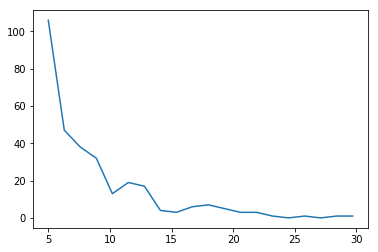

In [13]:
make_histogram(tracked_objs)

In [ ]:
tracker = cv2.TrackerMIL_create()

# Read video
video = cv2.VideoCapture("short copy (Converted).mov")

# Exit if video not opened.
if not video.isOpened():
    print "Could not open video"
    sys.exit()

# Read first frame.
ok, frame = video.read()
if not ok:
    print 'Cannot read video file'
    sys.exit()

# Define an initial bounding box
bbox = (287, 23, 86, 320)

# Uncomment the line below to select a different bounding box
bbox = cv2.selectROI(frame, False)

# Initialize tracker with first frame and bounding box
ok = tracker.init(frame, bbox)

while True:
    # Read a new frame
    ok, frame = video.read()
    if not ok:
        break

    # Update tracker
    ok, bbox = tracker.update(frame)

    # Draw bounding box
    if ok:
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (0,0,255))

    # Display result
    #cv2.imshow("Tracking", frame)
    videoWriter.write(frame)

    # Exit if ESC pressed
    k = cv2.waitKey(1) & 0xff
    if k == 27 : break

videoWriter.release()

In [ ]:
ret,frame=video.read()
gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
ret,thresh=cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

for c in contours:
    #find bounding box co-ordinates
    (x,y),radius=cv2.minEnclosingCircle(c)
    #cast to integers
    center=(int(x),int(y))
    radius=int(radius)
    #draw the circle
    img=cv2.circle(frame,center,radius,(0,255,0),2)
    
    #find minimum area
    rect=cv2.minAreaRect(c)
    #calculate co-ordinates of minimum area rectangle
    box=cv2.boxPoints(rect)
    #normalize co-ordinates to integers
    box=np.int0(box)
    #cv2.drawContours(frame,[box],-1,(0,0,255),3)

#cv2.drawContours(frame,contours,-1,(255,0,0),1)
plt.imshow(frame)